In [ ]:
%load_ext autoreload
%autoreload 2

import time
import math
import copy
import torch
from torch import nn, optim
import numpy as np
import awkward as ak
import uproot
import pandas as pd
import dask
import vector
import particle
import hepunits

import zuko
import torch
from torch import nn, optim
import lightning as L
from lightning.pytorch import loggers as pl_loggers

from torch.utils.data import DataLoader

from memflow.dataset.data import RootData,ParquetData
from dataset2 import *
from memflow.ttH.classifier.classifier_models import *

from ttH_dataclasses_multiplicity import ttHHardDataset, ttHRecoDataset

from classifier_callbacks import *
from memflow.ttH.models.callbacks import ModelCheckpoint

from matplotlib import pyplot as plt

plt.rcParams.update({'figure.max_open_warning': 100})

vector.register_awkward()

os.environ["CUDA_VISIBLE_DEVICES"] = "3"
print (f"Running on GPU : {torch.cuda.is_available()}")
accelerator = 'gpu' if torch.cuda.is_available() else 'cpu'
print (f"Accelerator : {accelerator}")
torch.set_float32_matmul_precision('medium')  
if accelerator =='gpu':
    torch.cuda.empty_cache()
    print (torch.cuda.memory_summary(device=None, abbreviated=True))

/software/sa21722/miniconda3/envs/mem-flow/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/software/sa21722/miniconda3/envs/mem-flow/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:15: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 12.0.1. Please consider upgrading.
  warnings.warn(


Running on GPU : True
Accelerator : gpu
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |      0 B   |      0 B   |      0 B   |      0 B   |
|---------------------------------------------------------------------------|
| Active memory         |      0 B   |      0 B   |      0 B   |      0 B   |
|---------------------------------------------------------------------------|
| Requested memory      |      0 B   |      0 B   |      0 B   |      0 B   |
|-----------------------

In [2]:
data_hard = ParquetData(
    files = [
        '/cephfs/dice/users/sa21722/datasets/MEM_data/ttH/TF_v6/hard/2018/ttH/ttH_HToInvisible_M125.parquet',
    ],
    lazy = True,
)
data_reco = ParquetData(
    files = [
        '/cephfs/dice/users/sa21722/datasets/MEM_data/ttH/TF_v6/reco/2018/ttH/ttH_HToInvisible_M125.parquet',
    ],
    lazy = True,
)
print(data_hard)

Data object
Loaded branches:
   ... file: 1903554
   ... sample: 1903554
   ... tree: 1903554
Branch in files not loaded:
   ... Generator_scalePDF
   ... Generator_weight
   ... Generator_x1
   ... Generator_x2
   ... Generator_xpdf1
   ... Generator_xpdf2
   ... W_minus_from_antitop_eta
   ... W_minus_from_antitop_genPartIdxMother
   ... W_minus_from_antitop_idx
   ... W_minus_from_antitop_mass
   ... W_minus_from_antitop_pdgId
   ... W_minus_from_antitop_phi
   ... W_minus_from_antitop_pt
   ... W_minus_from_antitop_status
   ... W_minus_from_antitop_statusFlags
   ... W_plus_from_top_eta
   ... W_plus_from_top_genPartIdxMother
   ... W_plus_from_top_idx
   ... W_plus_from_top_mass
   ... W_plus_from_top_pdgId
   ... W_plus_from_top_phi
   ... W_plus_from_top_pt
   ... W_plus_from_top_status
   ... W_plus_from_top_statusFlags
   ... Z_from_higgs_eta
   ... Z_from_higgs_genPartIdxMother
   ... Z_from_higgs_idx
   ... Z_from_higgs_mass
   ... Z_from_higgs_pdgId
   ... Z_from_higgs_phi

In [3]:
hard_dataset = ttHHardDataset(
    data = data_hard,
    selection = [
        # 'higgs',
        # 'tops',
        'bottoms',
        # 'Ws',
        # 'Zs',
        'quarks',
        'neutrinos',
    ],
    build = True,
    fit = True,
    coordinates = 'cylindrical',
    apply_preprocessing = True,
    apply_boost = False,
    dtype = torch.float32,
)
print(hard_dataset)

reco_dataset = ttHRecoDataset(
    data = data_reco,
    selection = [
        'jets',
        'met',
    ],
    build = True,
    fit = True,
    coordinates = 'cylindrical',
    apply_preprocessing = True,
    apply_boost = False,
    dtype = torch.float32,
)
print(reco_dataset)

Selecting 756642 events out of 1903554
Before cut: 1903554 events
After cut: 756642 events
Saving objects to /cephfs/dice/users/sa21722/projects/MEM/memflow/ttH/classifier/ttH_hard
Saving preprocessing to /cephfs/dice/users/sa21722/projects/MEM/memflow/ttH/classifier/ttH_hard
Will overwrite what is in output directory /cephfs/dice/users/sa21722/projects/MEM/memflow/ttH/classifier/ttH_hard/preprocessing
Preprocessing saved in /cephfs/dice/users/sa21722/projects/MEM/memflow/ttH/classifier/ttH_hard/preprocessing
Parton dataset with 756642 events
 Initial states pdgids : [21, 21]
 Final states pdgids   : [25, 6, -6]
 Final states masses   : [125.2, 172.57, 172.57]
Containing the following tensors
boost      : data ([756642, 1, 4]), mask ([756642, 1])
             Mask exist    : [100.00%]
             Mask attn     : [True]
             Weights       : 756642.00
             Features      : ['x', 'y', 'z', 't']
             Selected for batches : False
higgs      : data ([756642, 1, 5]), m

In [4]:
dataset = MultiplicityDataset(
    hard_dataset = hard_dataset,
    reco_dataset = reco_dataset,
    reco_object = 'jets', # name of the object to have the multiplicity based on
)

train_frac = 0.7
indices = torch.arange(len(dataset))
sep = int(train_frac*len(dataset))
train_indices = indices[:sep]
valid_indices = indices[sep:]

dataset_train = torch.utils.data.Subset(dataset,train_indices)
dataset_valid = torch.utils.data.Subset(dataset,valid_indices)

print (f'Dataset : training {len(dataset_train)} / validation {len(dataset_valid)}')

batch_size = 1024

loader_train = DataLoader(
    dataset_train,
    batch_size = batch_size,
    shuffle = True,
)
loader_valid = DataLoader(
    dataset_valid,
    batch_size = 10000,
    shuffle = False,
)
print (f'Batching {len(loader_train)} / Validation {len(loader_valid)}')

Intersection branches : `event` for hard dataset and `event` for reco dataset
Looking into file metadata
Will pair these files together :
   - /cephfs/dice/users/sa21722/datasets/MEM_data/ttH/TF_v6/hard/2018/ttH/ttH_HToInvisible_M125.parquet <-> /cephfs/dice/users/sa21722/datasets/MEM_data/ttH/TF_v6/reco/2018/ttH/ttH_HToInvisible_M125.parquet
For entry 0 : from 756642 events, 168536 selected
For entry 1 : from 231528 events, 168536 selected
Dataset : training 117975 / validation 50561
Batching 116 / Validation 6


Before preprocessing for hard


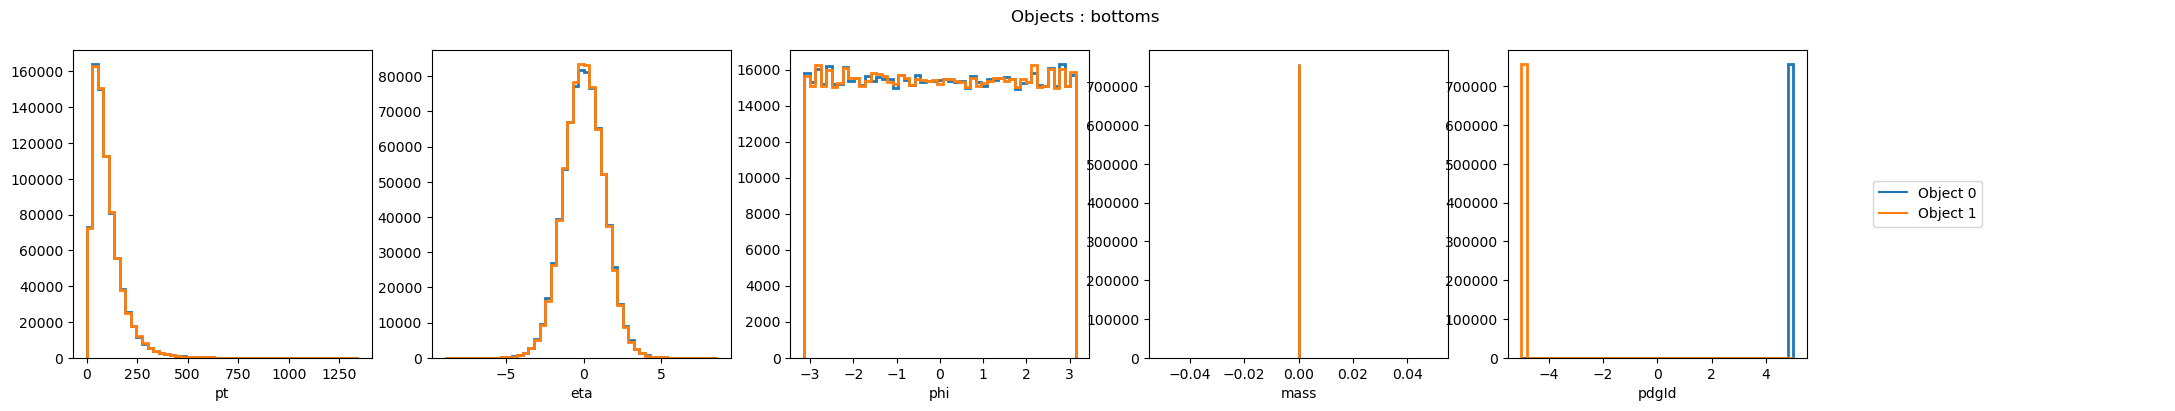

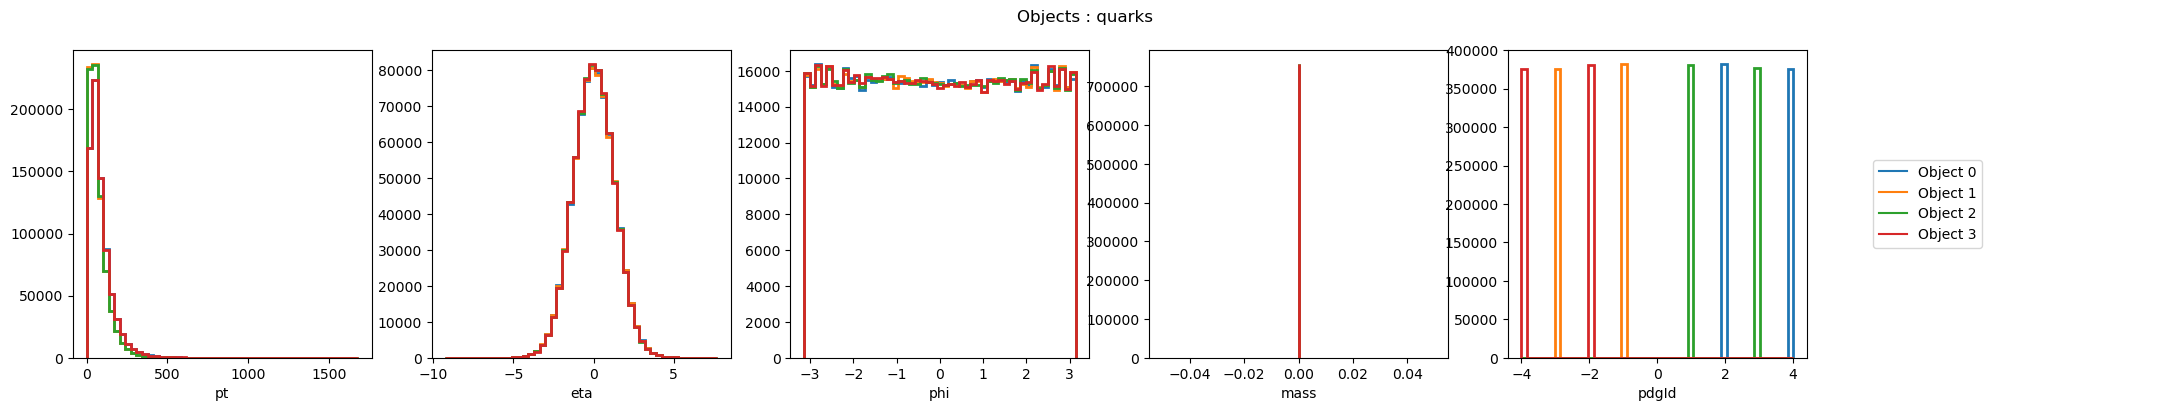

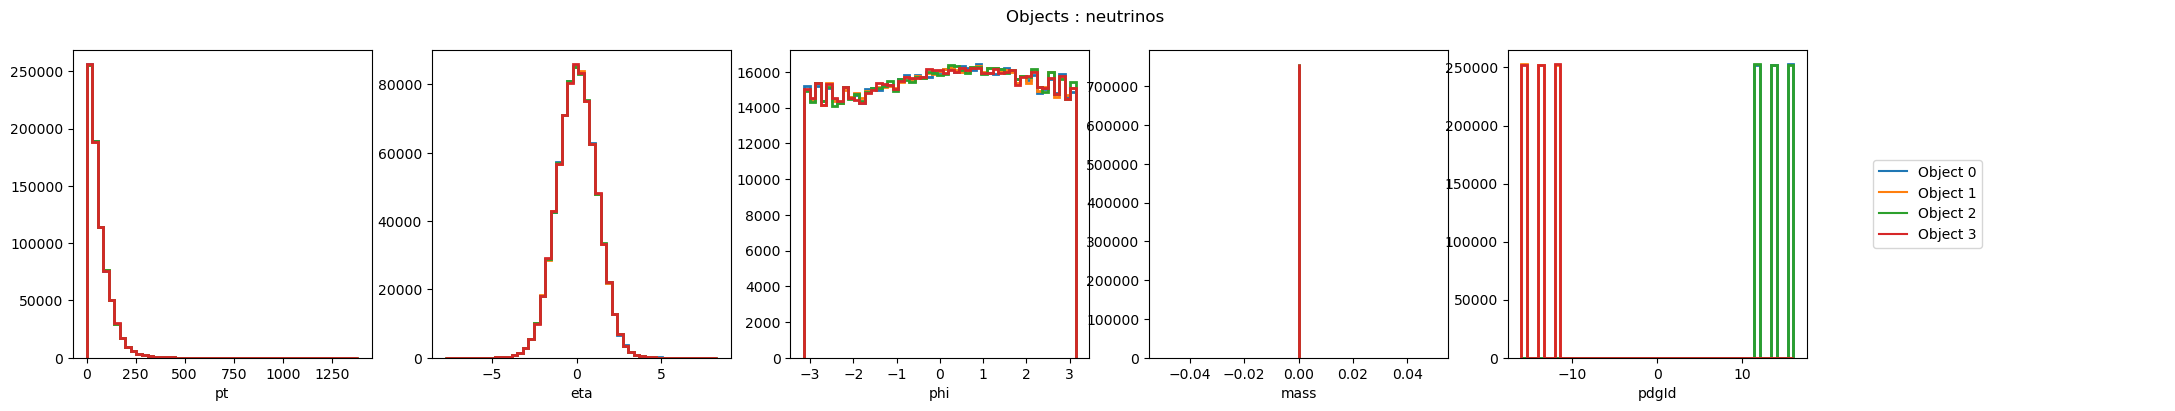

After preprocessing for hard


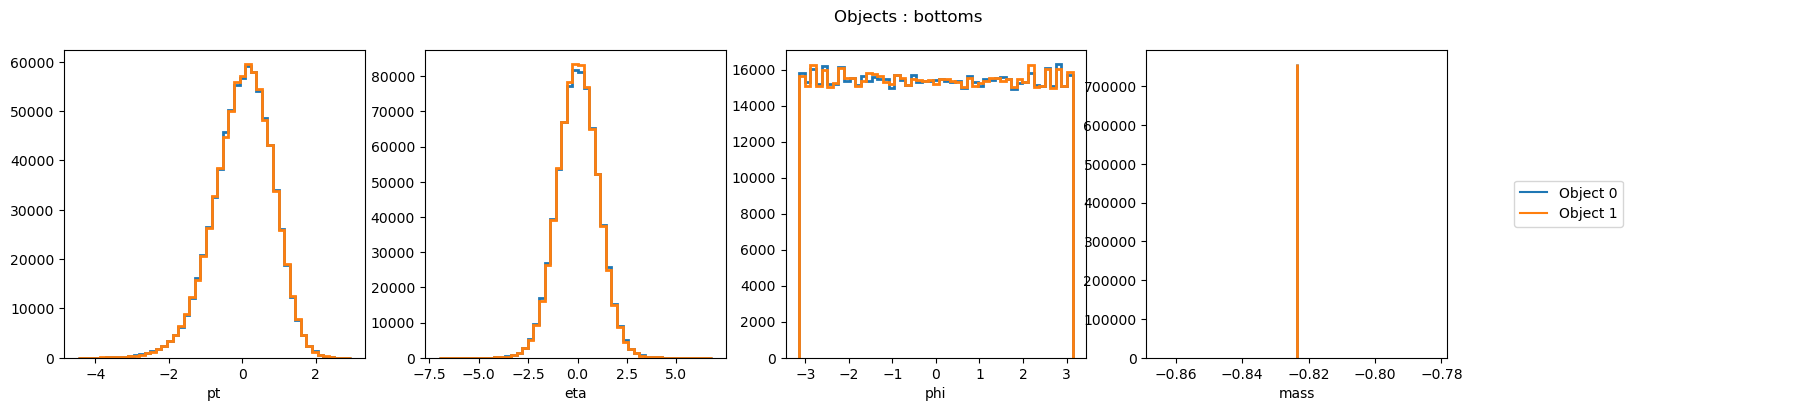

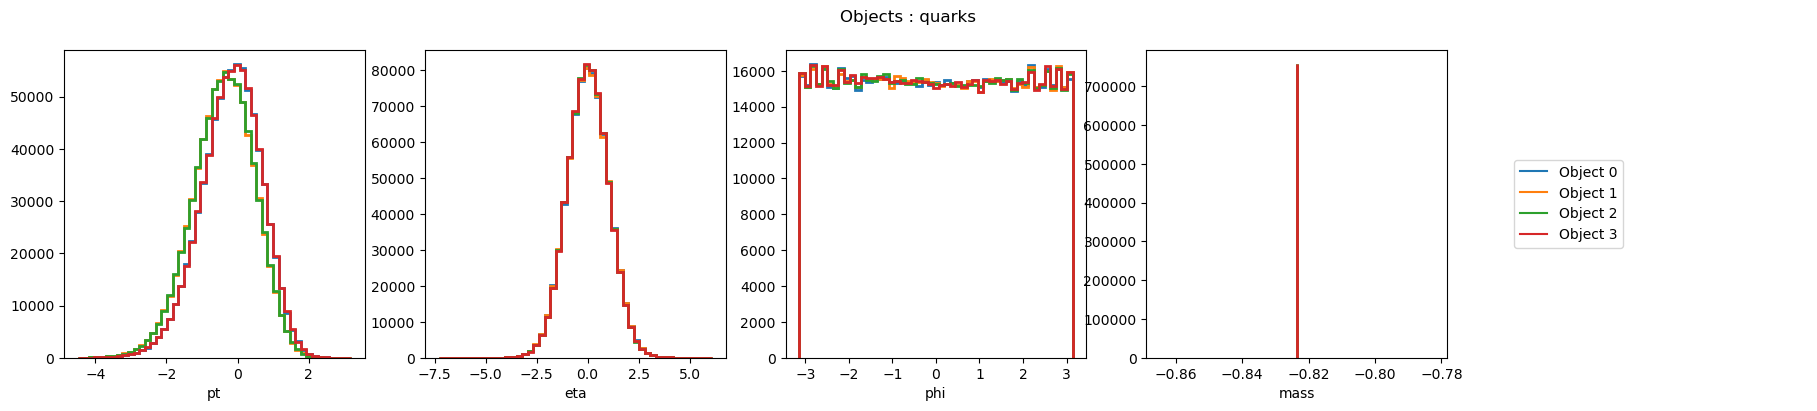

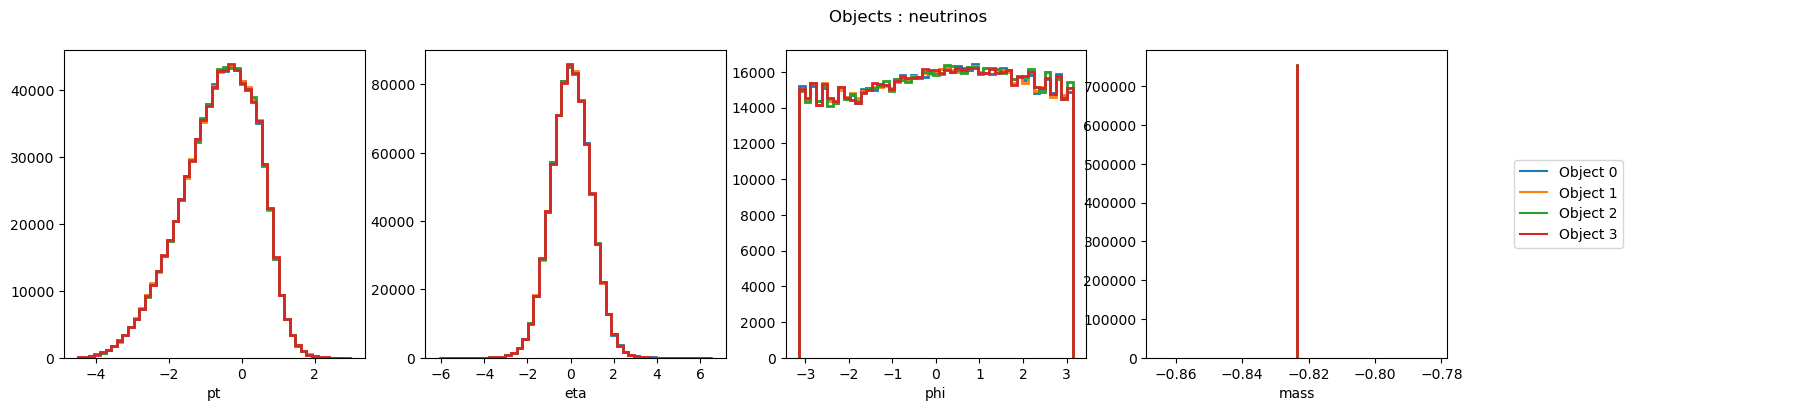

Before preprocessing for reco
After preprocessing for reco


In [5]:
print("Before preprocessing for hard")
dataset.hard_dataset.plot(selection=True,raw=True,log=False)
print("After preprocessing for hard")
dataset.hard_dataset.plot(selection=True,raw=False,log=False,fields_to_plot=['pt','eta','phi','mass','pdgid'])
print("Before preprocessing for reco")
print("After preprocessing for reco")

In [6]:
# We want a model that can classify between selected (1) and not selected (0)
# We can either use a fully connected network
# backbone : DNN
# head : DNN

# backbone = BaseMLP(
#     dim_in = dataset.flatten_dim,
#     dim_out = None,
#     neurons = [64]*5, #[64]*3,
#     hidden_activation = nn.GELU,
#     batch_norm = True,
#     dropout = 0.25,
# )

# head = BaseMLP(
#     dim_in = 64,
#     dim_out = dataset.target_dim,
#     output_activation = None,
#     batch_norm = True,
#)

# Or we can use
# backbone : transformer (+ mean pooling)
# head : DNN

backbone = BaseTransformerEncoder(
    n_particles_per_type = dataset.hard_dataset.number_particles_per_type,
    particle_type_names = dataset.hard_dataset.selection,
    input_features_per_type = dataset.hard_dataset.input_features,
    embed_dims = [64,256],
    activation = nn.GELU,
    num_layers = 5,
    nhead = 8,
    dim_feedforward = 256,
    layer_norm = True,
    dropout = 0.2,
)
head = BaseMLP(
    dim_in = 256,
    neurons = [128,64,32],
    dim_out = dataset.target_dim,
    output_activation = None,
    batch_norm = True,
)

# Combine the backbone and head into classifier
model = Classifier(
    backbone = backbone,
    head = head,
    loss_function = nn.CrossEntropyLoss(reduction='none'),
)
print (model)

batch = next(iter(loader_train))

out = model(batch)
print (out.shape)

loss = model.shared_eval(batch,0,'test')
print(loss)

/software/sa21722/miniconda3/envs/mem-flow/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'backbone' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['backbone'])`.
/software/sa21722/miniconda3/envs/mem-flow/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'head' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['head'])`.
/software/sa21722/miniconda3/envs/mem-flow/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss_function' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_function'])`.


Classifier(
  (backbone): BaseTransformerEncoder(
    (embeddings): ModuleList(
      (0-2): 3 x Sequential(
        (0): Linear(in_features=5, out_features=64, bias=True)
        (1): GELU(approximate='none')
        (2): Linear(in_features=64, out_features=256, bias=True)
      )
    )
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-4): 5 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
          )
          (linear1): Linear(in_features=256, out_features=256, bias=True)
          (dropout): Dropout(p=0.2, inplace=False)
          (linear2): Linear(in_features=256, out_features=256, bias=True)
          (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.2, inplace=False)
          (dropout2): Dropout(p=0.2, inplace=False

/software/sa21722/miniconda3/envs/mem-flow/lib/python3.10/site-packages/lightning/pytorch/core/module.py:441: You are trying to `self.log()` but the `self.trainer` reference is not registered on the model yet. This is most likely because the model hasn't been passed to the `Trainer`


In [7]:
multiplicity = MultiplicityCallback(
    # Boilerplate arguments #
    dataset = dataset_valid,
    selection = dataset.hard_dataset.selection,
    features_per_type = dataset.hard_dataset.input_features,
    preprocessing = dataset.hard_dataset.preprocessing,
    # Plotting arguments #
    frequency = 50,     # frequency of plotting as callback
    raw = True,        # undo preprocessing (see raw values)
    bins = 50,         # number of bins for histograms
    log_scale = False, # whether to use log scale for plots
    batch_size = 10000,# number of events per batch for model evaluation
    # N_batch = 1,     # cutdown number of batches used (to make it faster, optional)
    # min and max number of objects for plots
    N_min = dataset.N_min,
    N_max = dataset.N_max,
    label_names = { # rename option to make plot labels nicer (optional)
        'pt'   : r'$p_T$',
        'eta'  : r'$\eta$',
        'phi'  : r'$\phi$',
        'mass' : r'$M$',
        'pdgId': r'PDG ID',
    }
)

In [8]:
## Parameters #####
epochs = 51
steps_per_epoch_train = math.ceil(len(dataset_train)/loader_train.batch_size)

print (f'Training   : Batch size = {loader_train.batch_size} => {steps_per_epoch_train} steps per epoch')
##### Optimizer #####
optimizer = optim.RAdam(model.parameters(), lr=1e-4, weight_decay=1e-6)
model.set_optimizer(optimizer)

##### Scheduler #####
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer = optimizer,
    mode = 'min', 
    factor = 0.5, 
    patience = 10, 
    threshold = 0., 
    threshold_mode = 'rel', 
    cooldown = 0, 
    min_lr = 1e-7,
)
model.set_scheduler_config(
    {
        'scheduler' : scheduler,
        'interval' : 'step' if isinstance(scheduler,optim.lr_scheduler.OneCycleLR) else 'epoch',
        'frequency' : 1,
        'monitor' : 'val/loss_tot',
        'strict' : True,
        'name' : 'scheduler',
    }
)


##### Callbacks #####
callbacks = [
    L.pytorch.callbacks.LearningRateMonitor(logging_interval='epoch'),
    L.pytorch.callbacks.ModelSummary(max_depth=2),
    multiplicity,
    ModelCheckpoint(save_every_n_epochs=25, save_dir="trained_model_checkpoints/multiplicity_checkpoints")
] 

##### Logger #####
logger = pl_loggers.CometLogger(
    save_dir = '../comet_logs',
    project_name = 'mem-flow-HH',
    experiment_name = 'Multiplicity',
    offline = False,
) 
logger.log_graph(model)
# logger.log_hyperparams()
# logger.experiment.log_code(folder='../src/')
logger.experiment.log_notebook(filename='multiplicity_process_DL.ipynb',overwrite=True)

##### Trainer #####
trainer = L.Trainer(    
    min_epochs = 5,
    max_epochs = epochs,
    callbacks = callbacks,
    devices = 'auto',
    accelerator = accelerator,
    logger = logger,
    log_every_n_steps = steps_per_epoch_train,
)
##### Fit #####
trainer.fit(
    model = model, 
    train_dataloaders = loader_train,
    val_dataloaders = loader_valid,
)

Training   : Batch size = 1024 => 116 steps per epoch


CometLogger will be initialized in online mode
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: sklearn, torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/themrluke/mem-flow-hh/b89f2b3683344d778d6f0eed9ab01bcb

Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]

  | Name                | Type                   | Params | Mode 
-----------------------------------------------------------------------
0 | backbone            | BaseTransformerEncoder | 2.0 M  | train
1 |

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/software/sa21722/miniconda3/envs/mem-flow/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.
/software/sa21722/miniconda3/envs/mem-flow/lib/python3.10/site-packages/torch/nn/modules/transformer.py:380: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. (Triggered internally at /opt/conda/conda-bld/pytorch_1699449181202/work/aten/src/ATen/NestedTensorImpl.cpp:178.)
  output = torch._nested_tensor_from_mask(output, src_key_padding_mask.logical_not(), mask_check=False)
/software/sa21722/miniconda3/envs/mem-flow/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the va

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Checkpoint saved at epoch 25: trained_model_checkpoints/multiplicity_checkpoints/model_epoch_25.ckpt


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Checkpoint saved at epoch 50: trained_model_checkpoints/multiplicity_checkpoints/model_epoch_50.ckpt


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=51` reached.
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : Multiplicity
COMET INFO:     url                   : https://www.comet.com/themrluke/mem-flow-hh/b89f2b3683344d778d6f0eed9ab01bcb
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     scheduler [51]      : (1.25e-05, 0.0001)
COMET INFO:     train/loss_tot [51] : (1.4319039583206177, 1.6123369932174683)
COMET INFO:     val/loss_tot [51]   : (1.5269277095794678, 1.5614579916000366)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO:     Name         : Multiplicity
COMET INFO:   Parameters:
COMET INFO:     backbone      : BaseTransformerEncoder(
  (embeddings): ModuleList

In [11]:
multiplicity_model = Classifier.load_from_checkpoint(checkpoint_path="trained_model_checkpoints/multiplicity_checkpoints/model_epoch_50.ckpt")
multiplicity_model.eval()

Classifier(
  (backbone): BaseTransformerEncoder(
    (embeddings): ModuleList(
      (0-2): 3 x Sequential(
        (0): Linear(in_features=5, out_features=64, bias=True)
        (1): GELU(approximate='none')
        (2): Linear(in_features=64, out_features=256, bias=True)
      )
    )
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-4): 5 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
          )
          (linear1): Linear(in_features=256, out_features=256, bias=True)
          (dropout): Dropout(p=0.2, inplace=False)
          (linear2): Linear(in_features=256, out_features=256, bias=True)
          (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.2, inplace=False)
          (dropout2): Dropout(p=0.2, inplace=False

Predict: 100%|██████████| 6/6 [00:05<00:00,  1.02it/s]


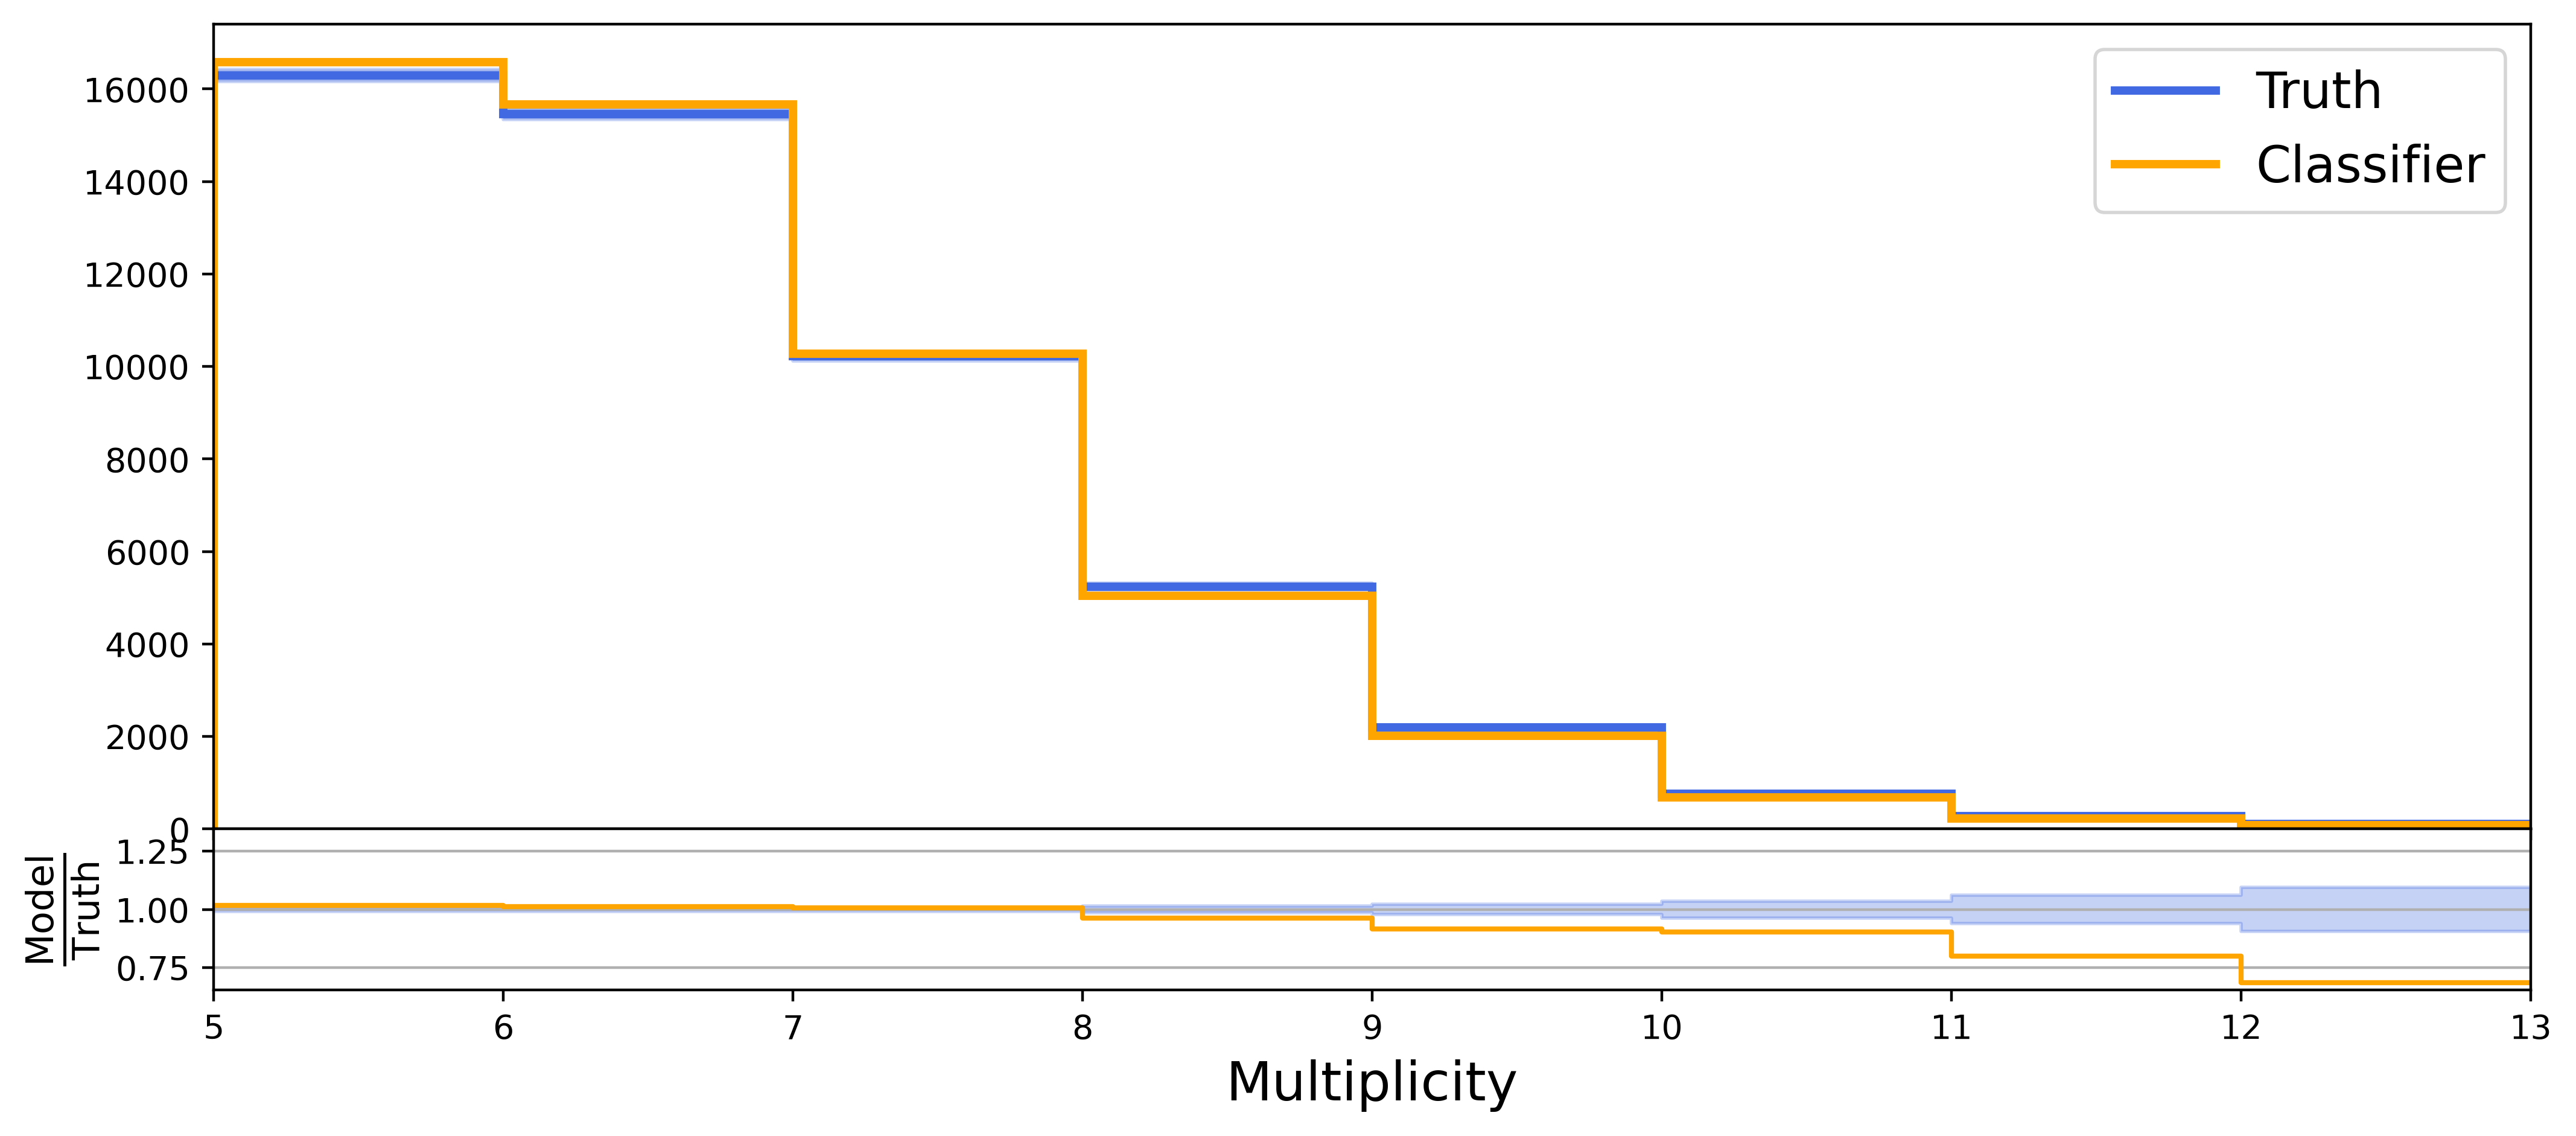

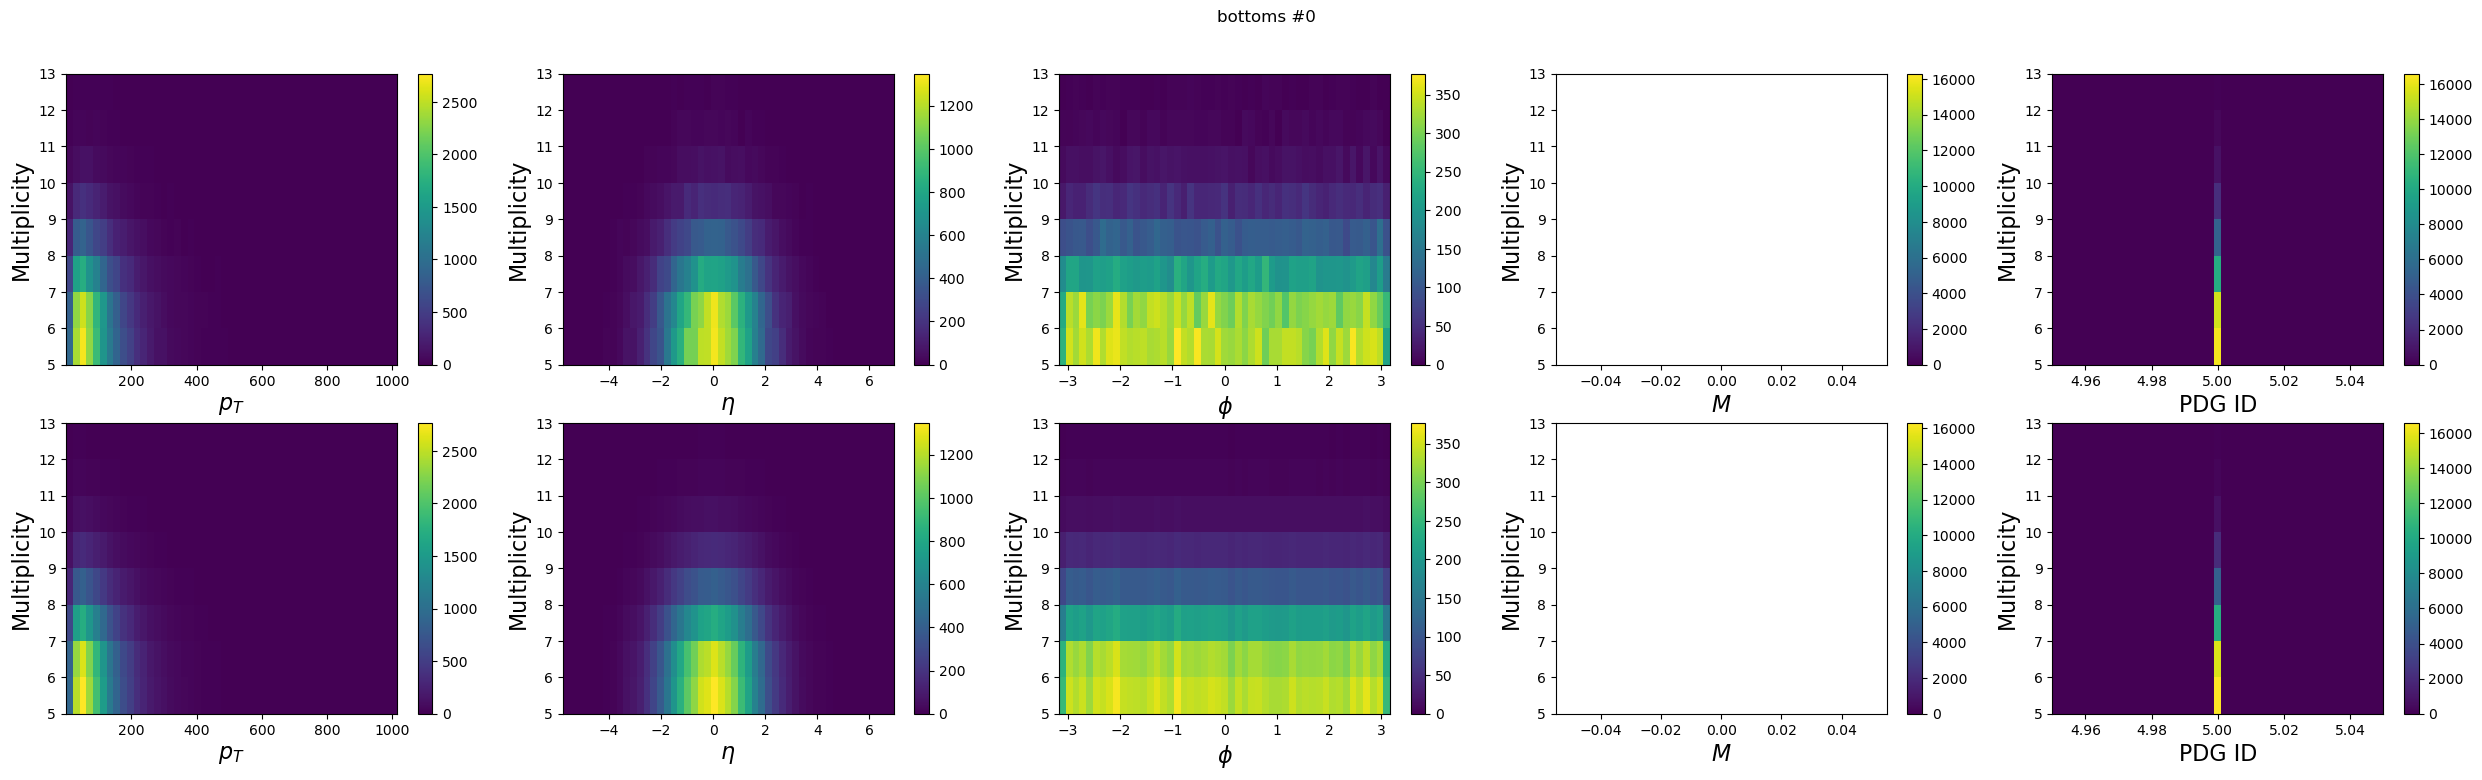

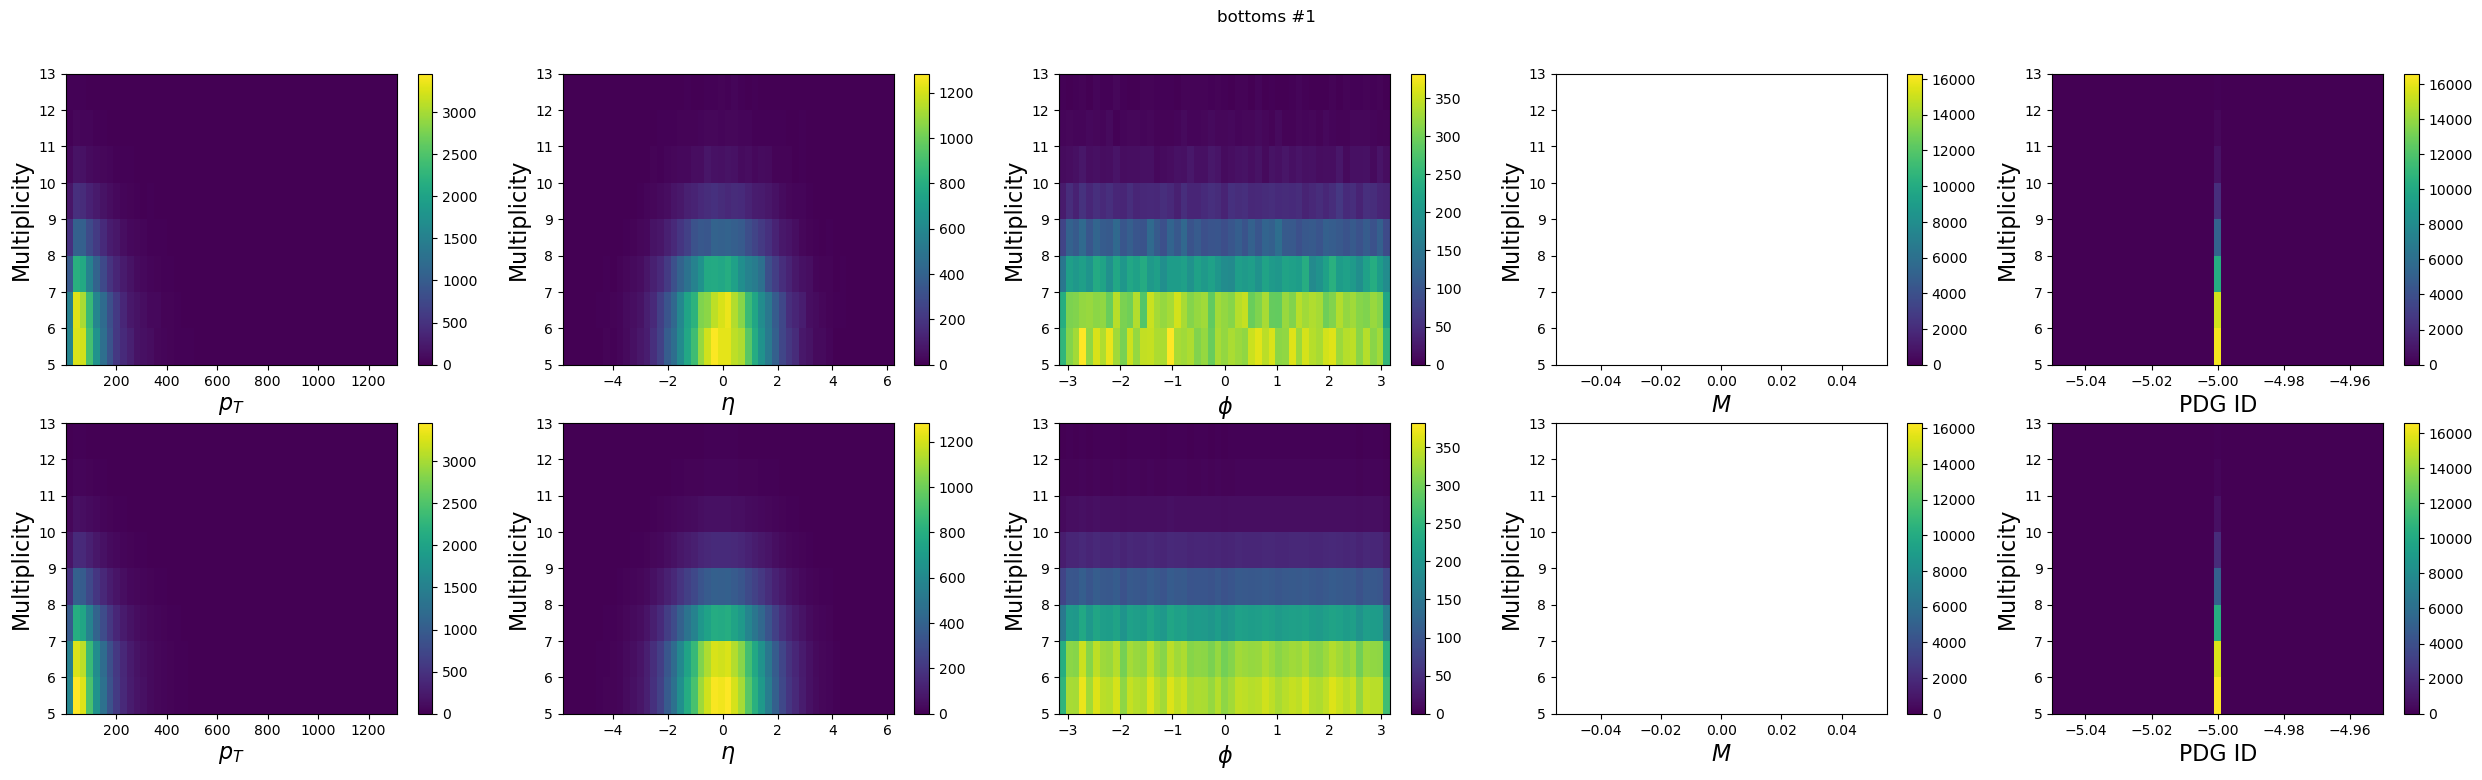

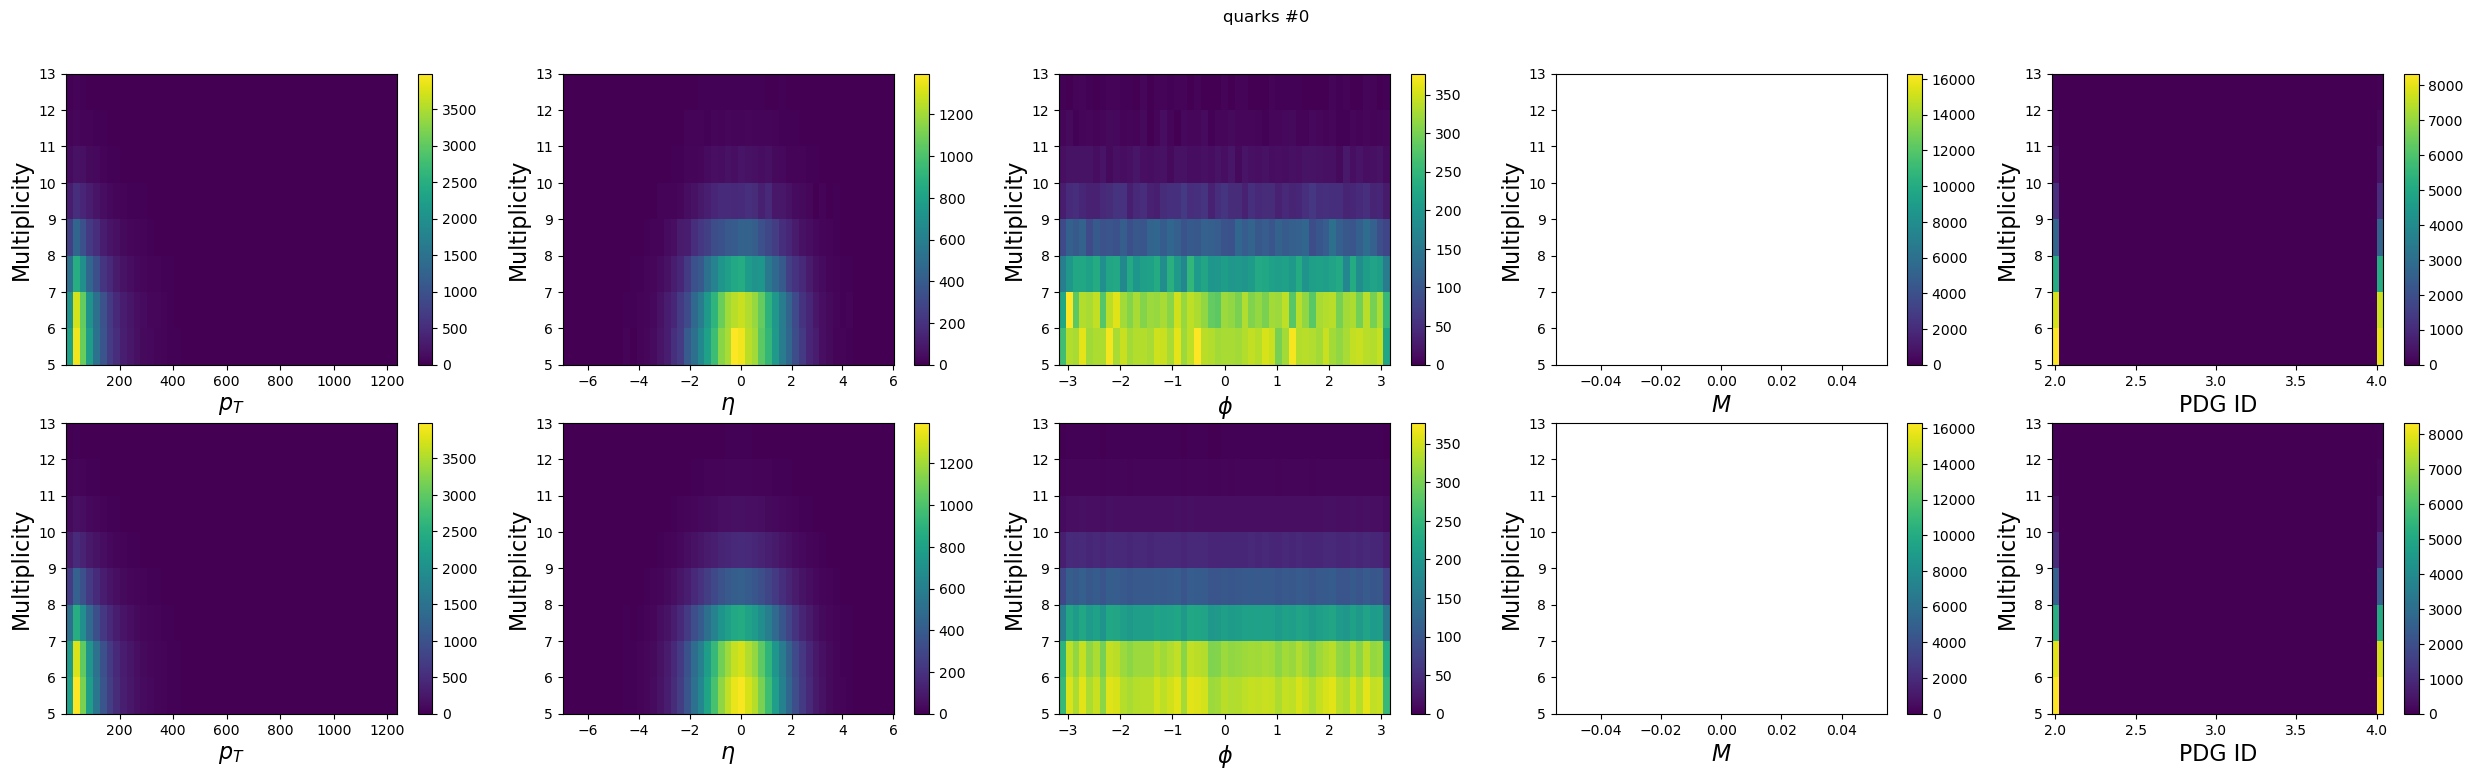

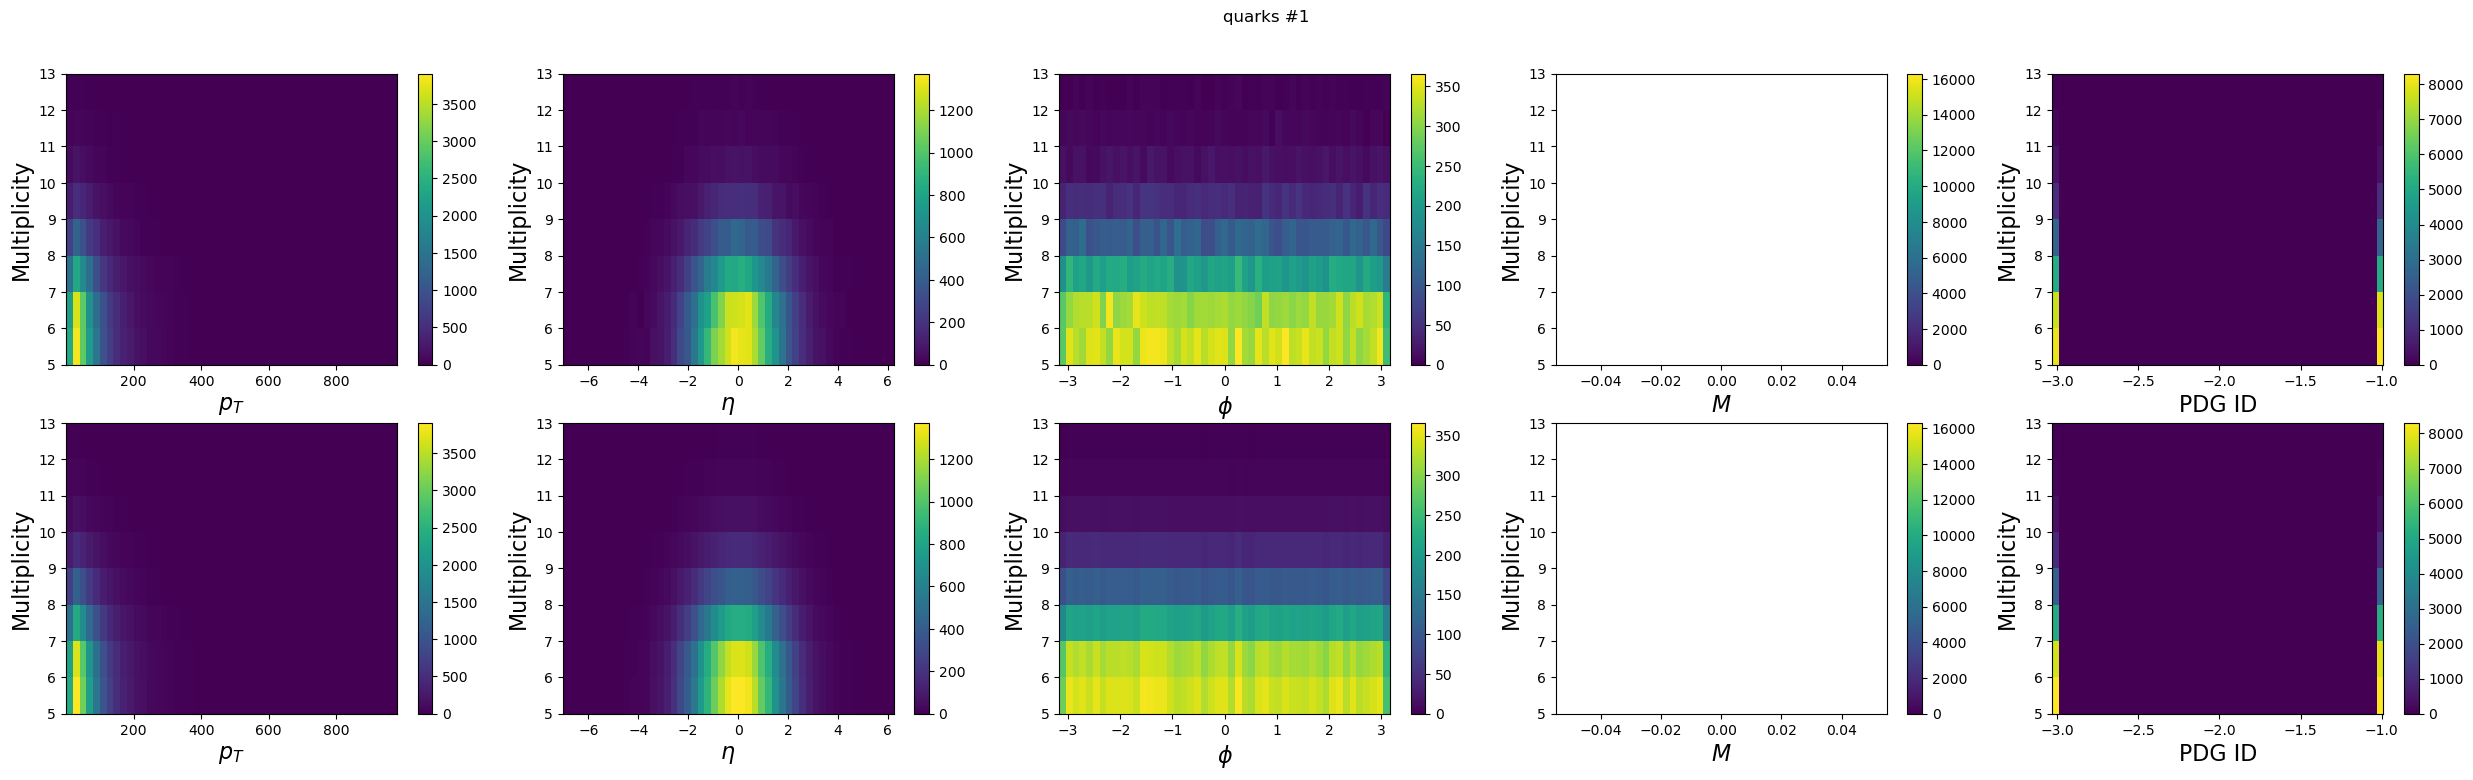

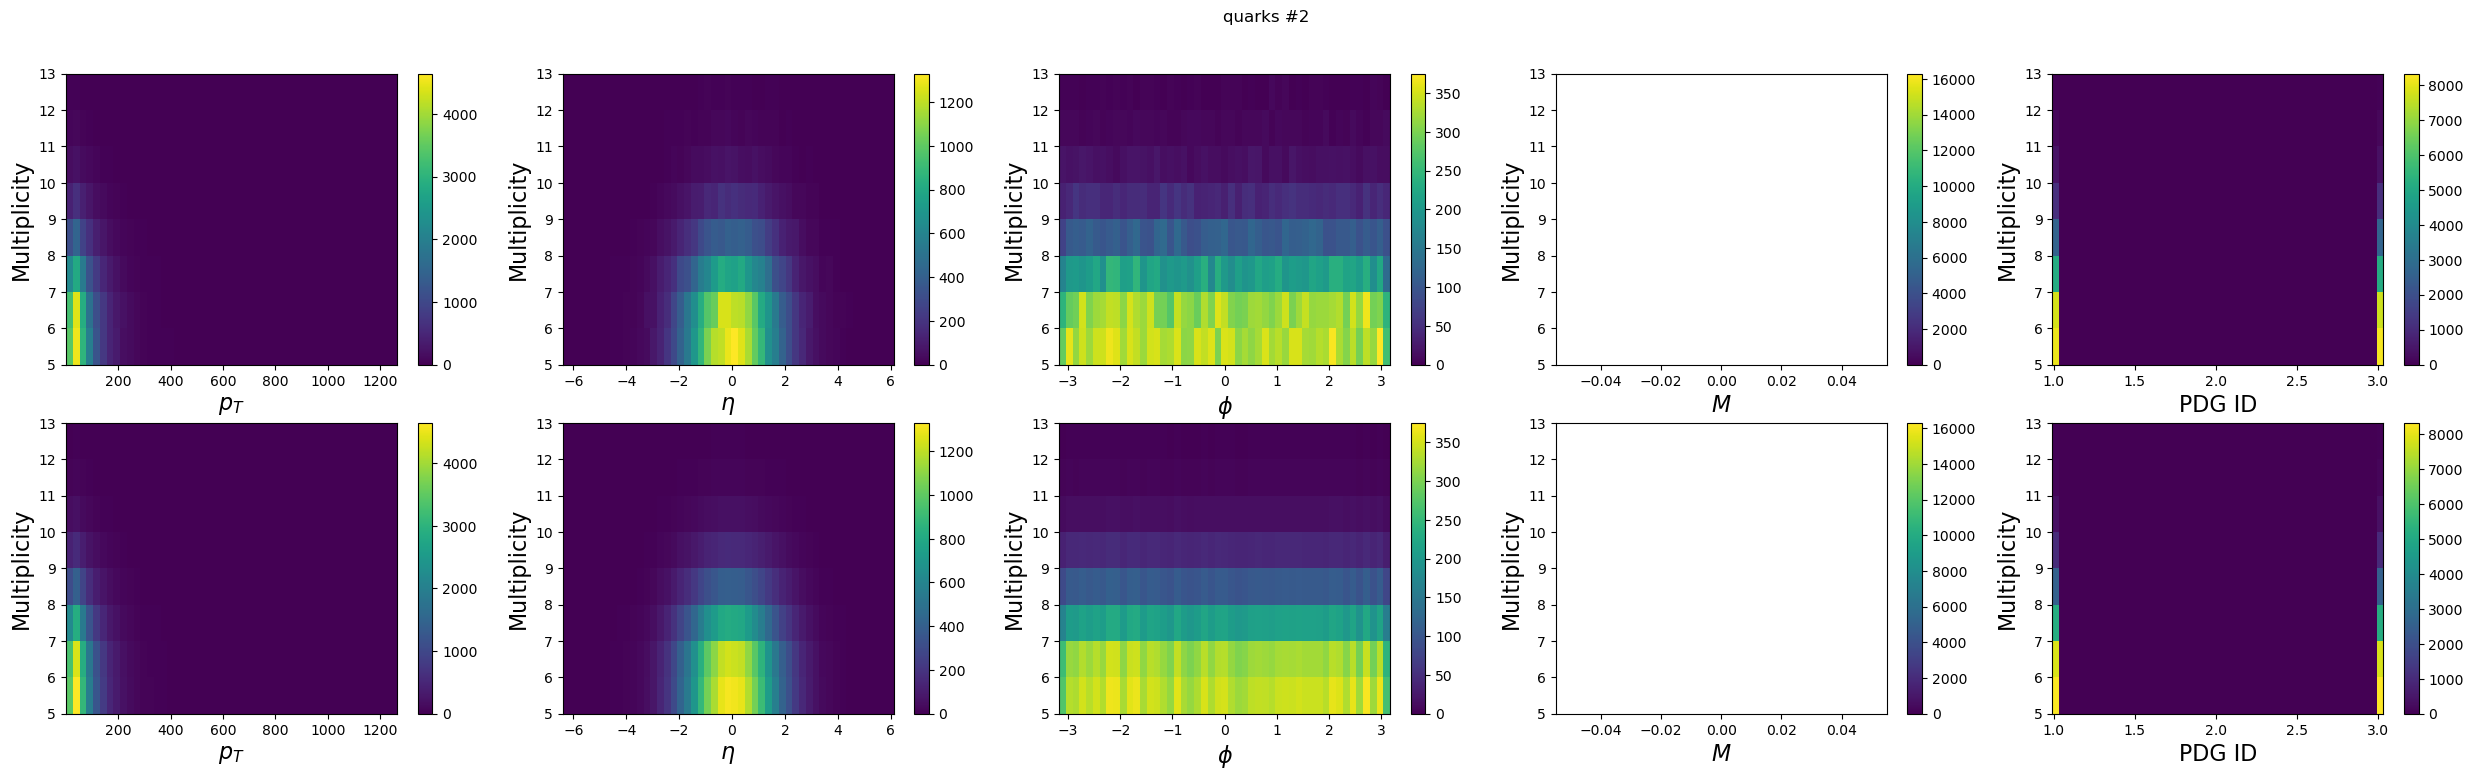

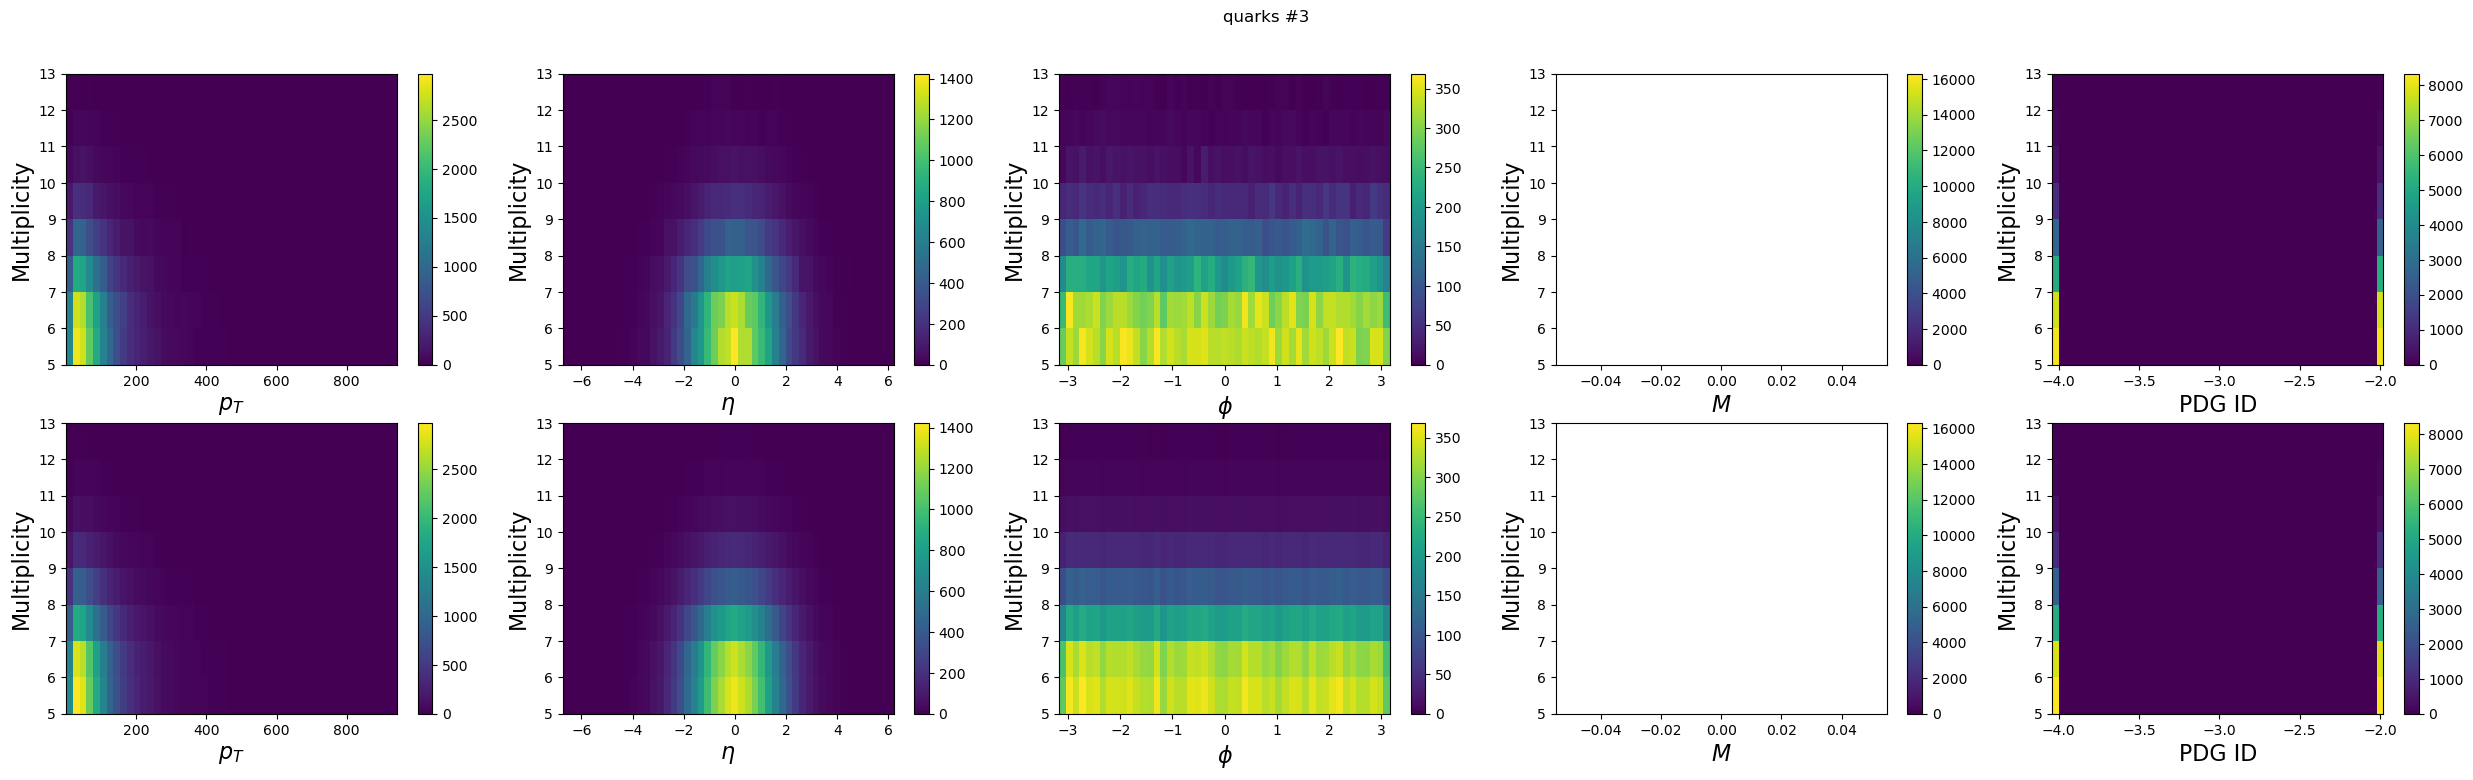

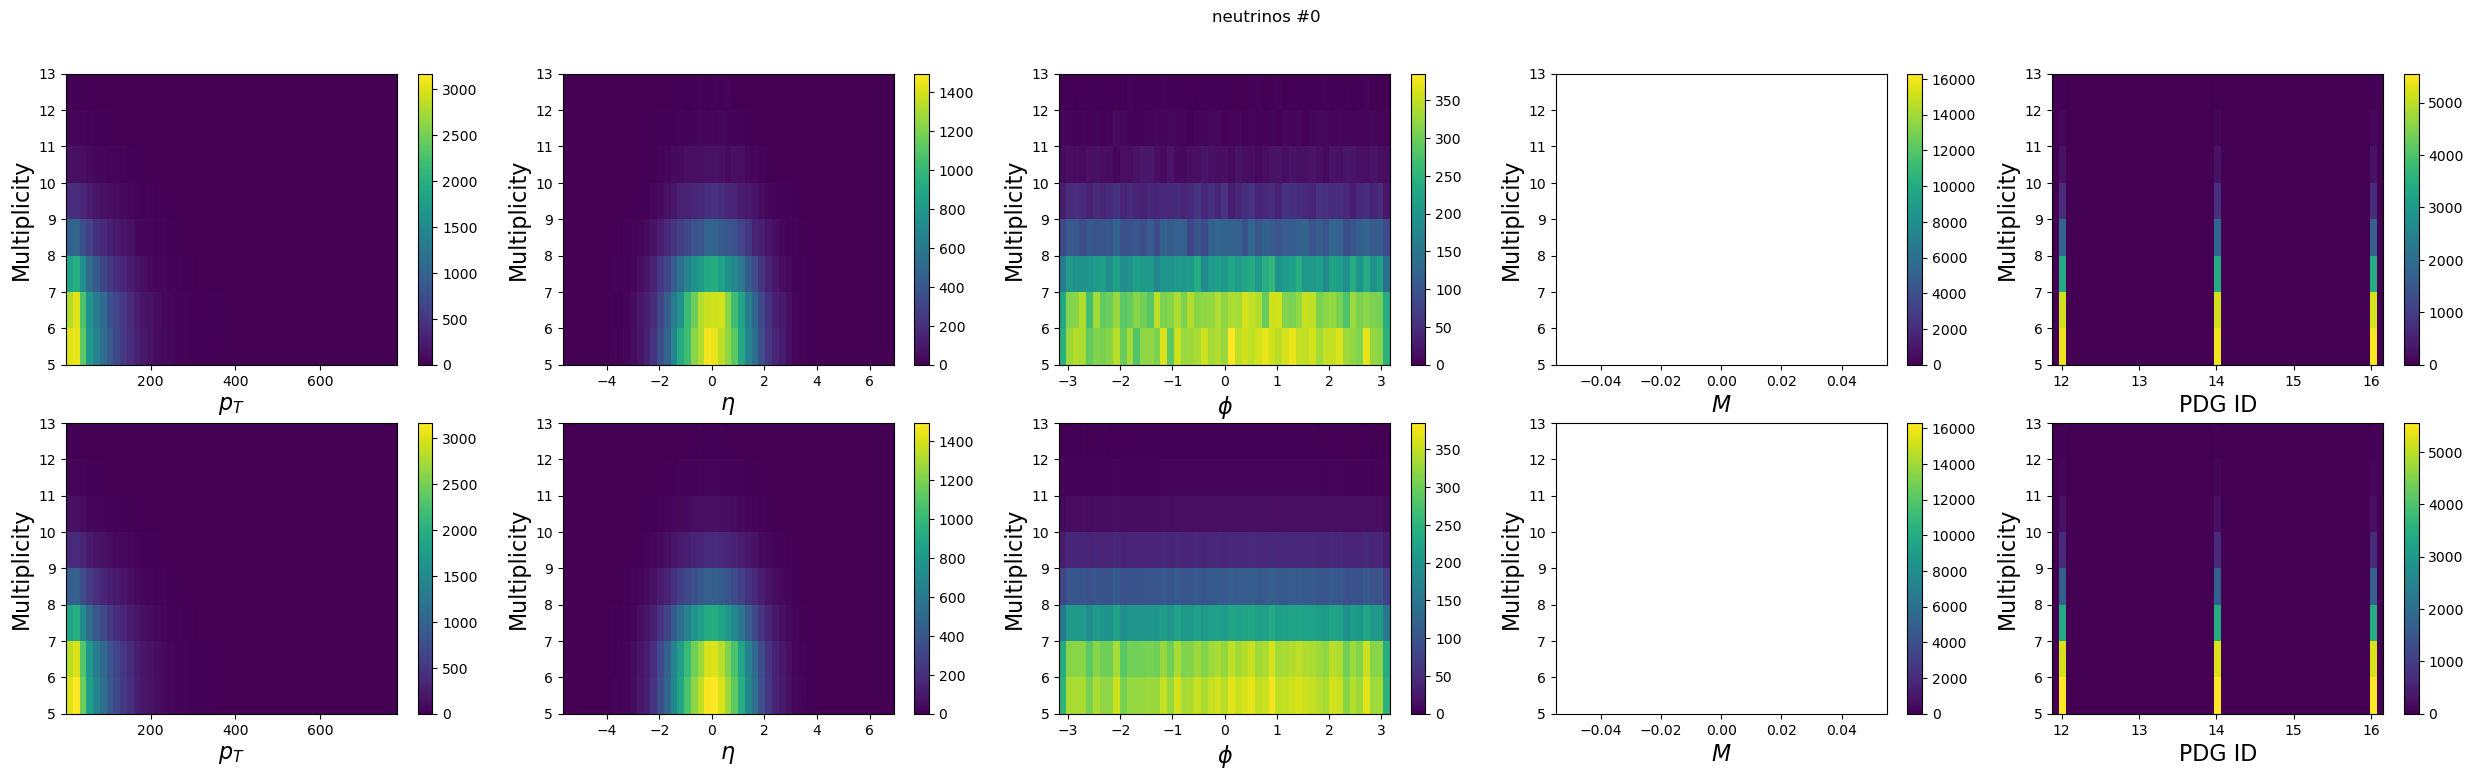

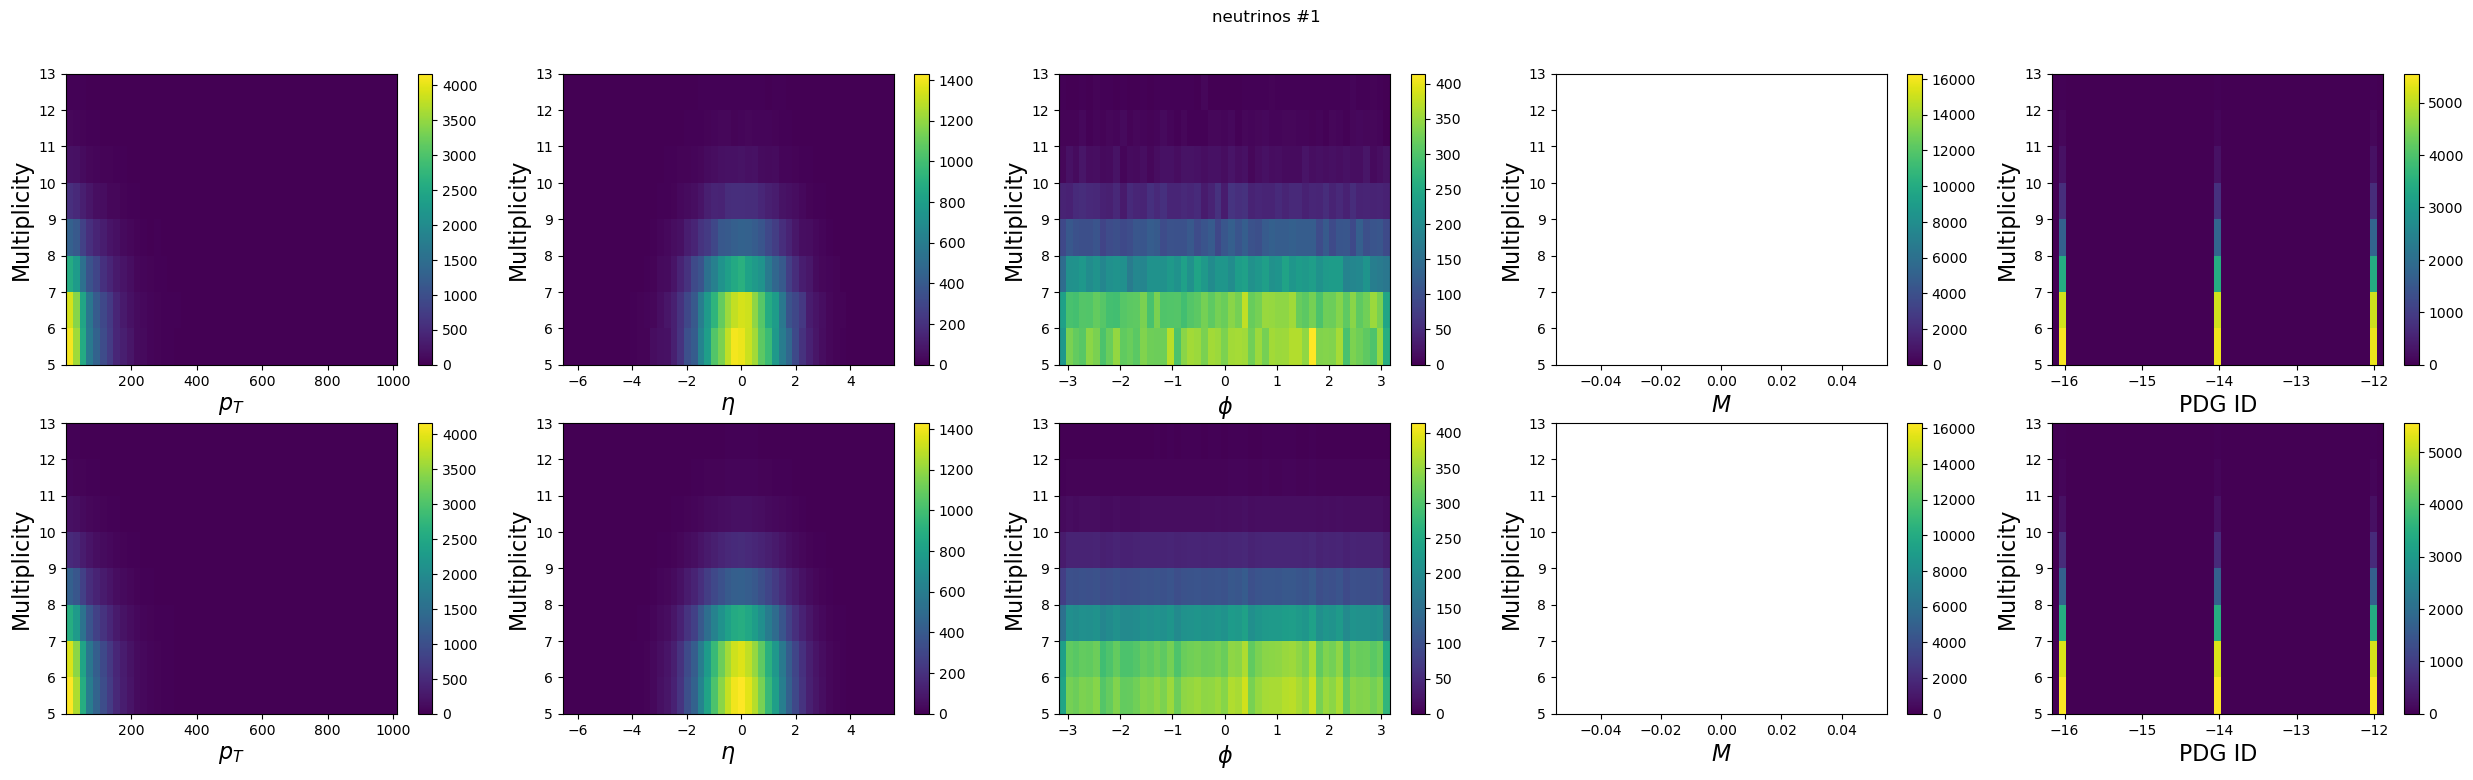

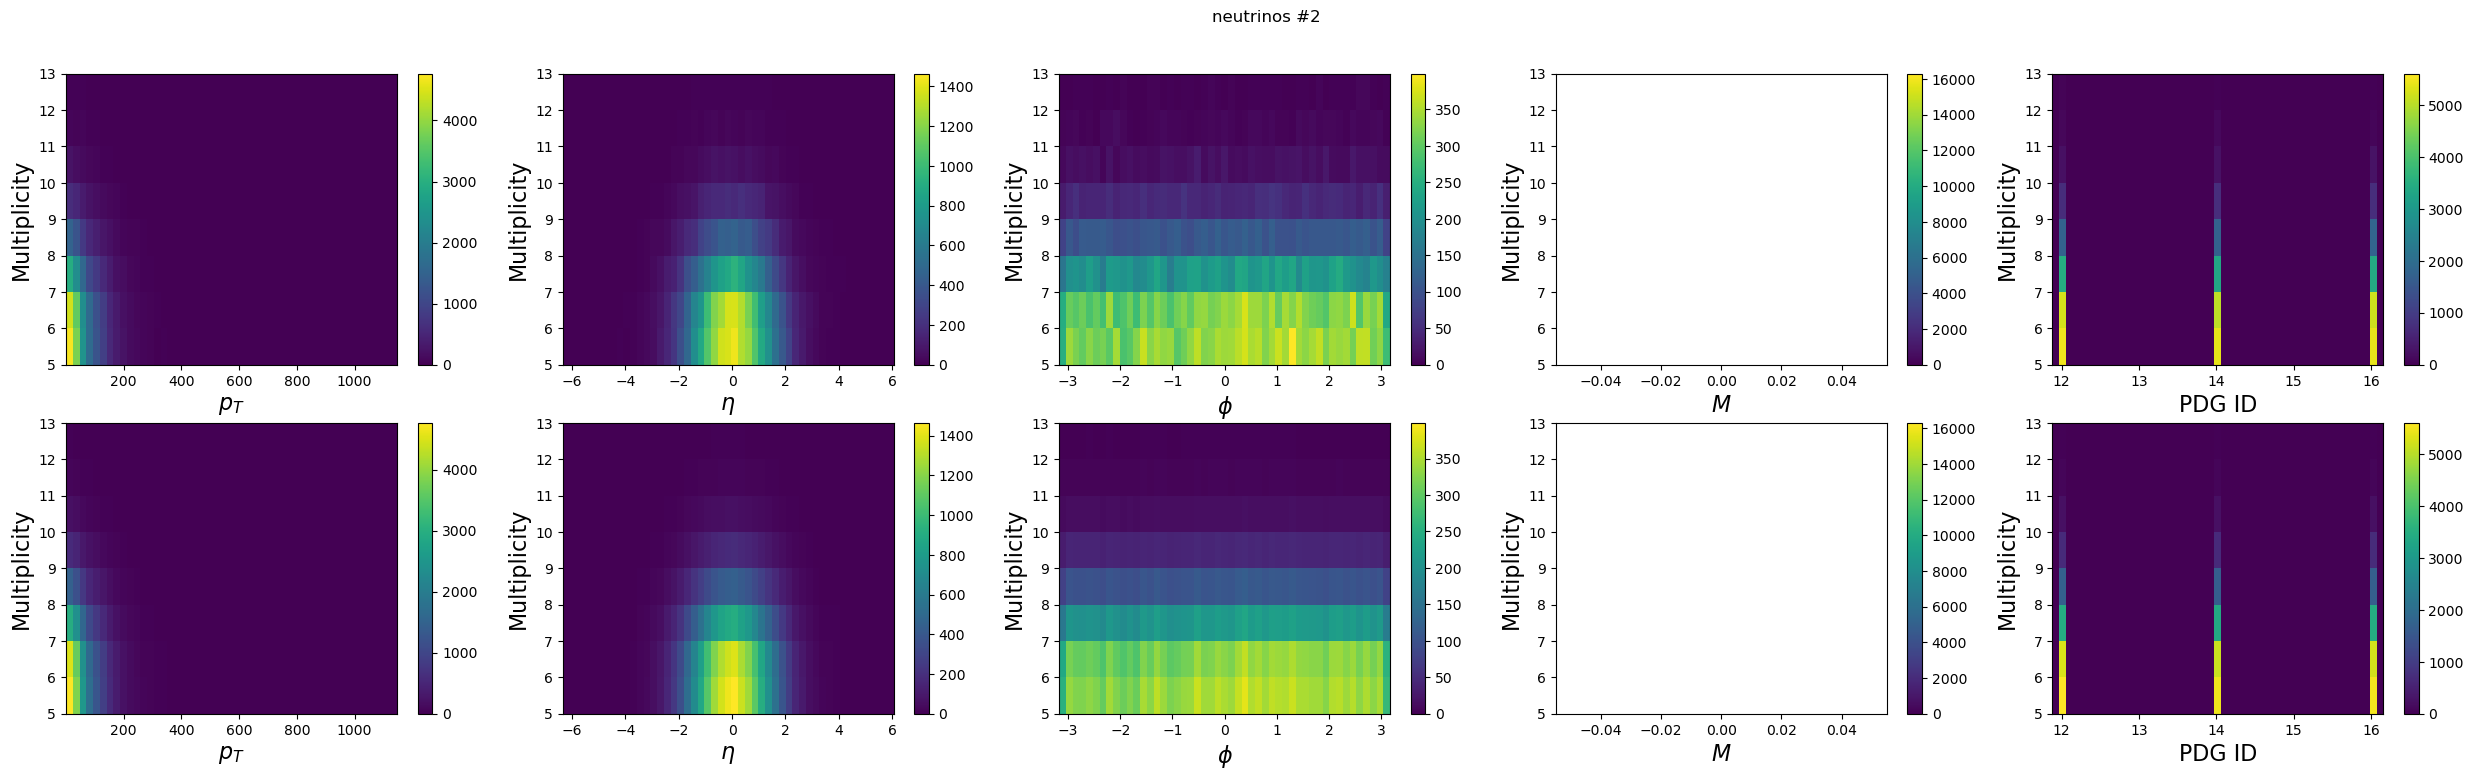

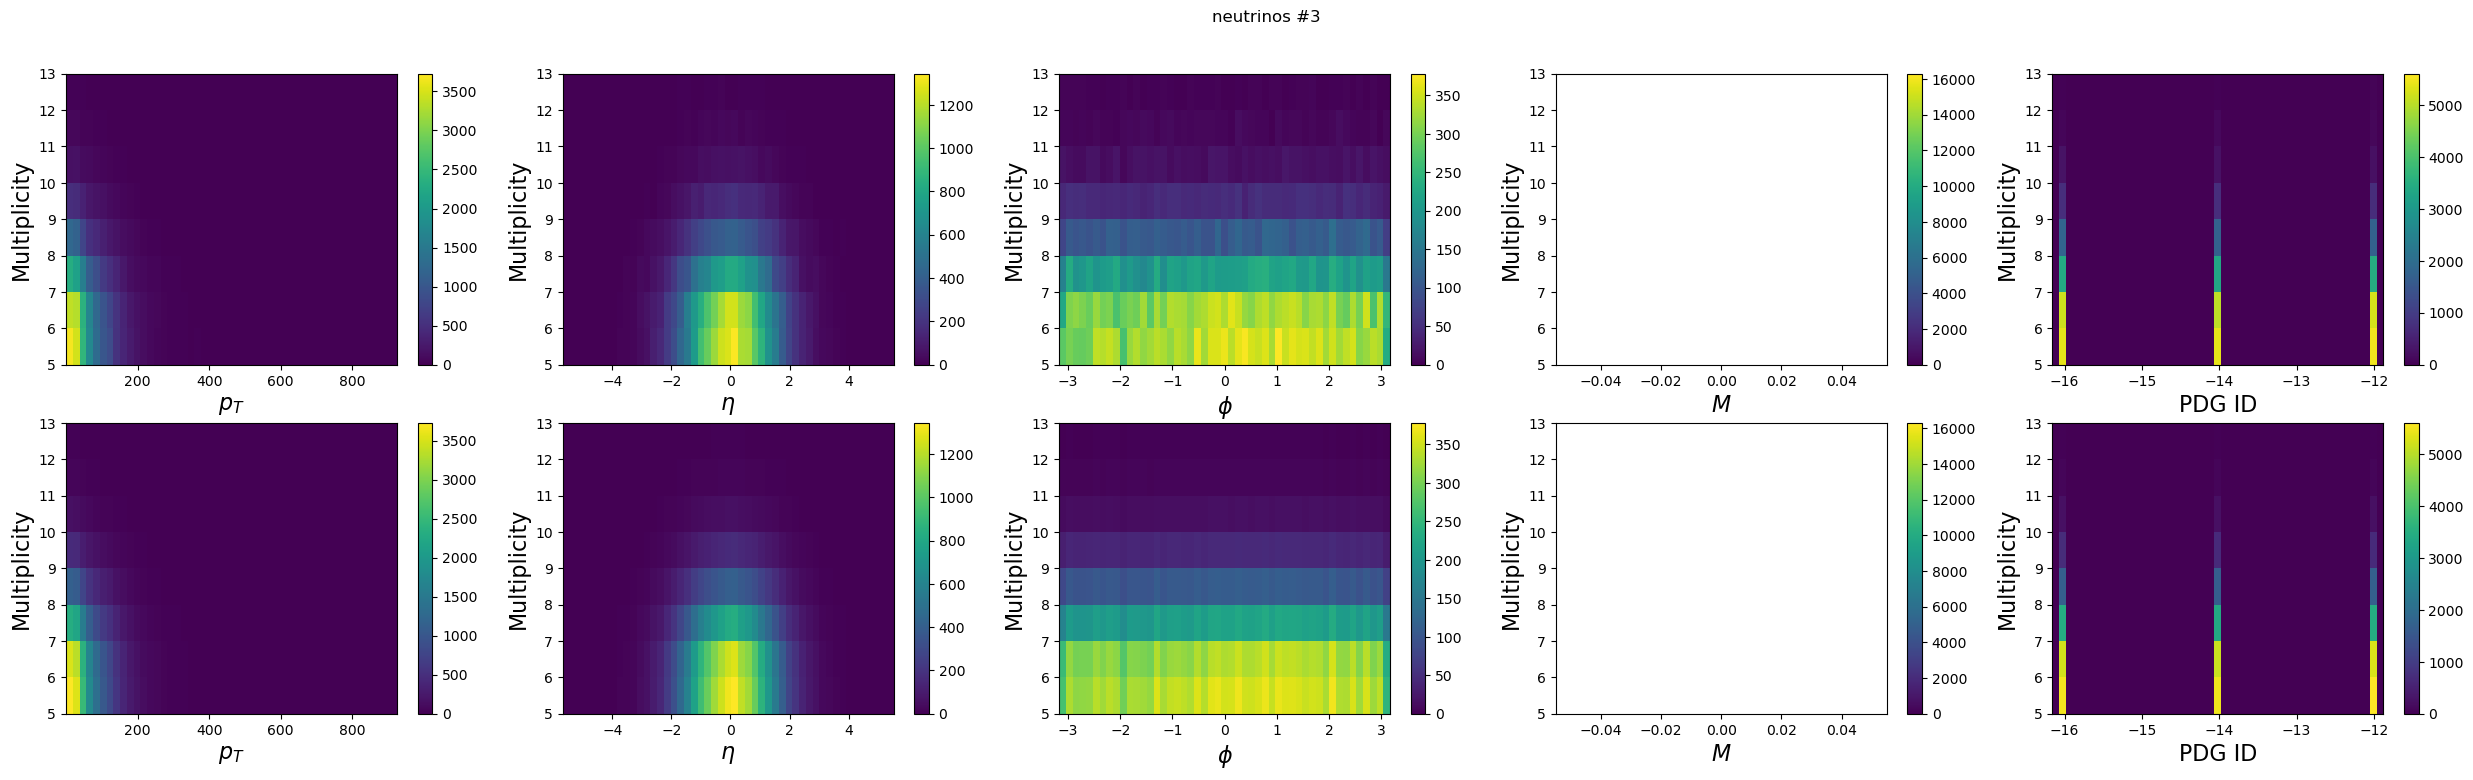

In [13]:
multiplicity.N_batch = np.inf
figs = multiplicity.make_plots(model=multiplicity_model.cuda(),show=True)